## 1. Regresión Lineal Ordinaria

### a. Carga de datos

In [1]:
import pandas as pd
import numpy as np

url = 'http://statweb.stanford.edu/~tibs/ElemStatLearn/datasets/prostate.data'
df = pd.read_csv(url, sep='\t', header=0)
df = df.drop('Unnamed: 0', axis=1)
istrain_str = df['train']
istrain = np.asarray([True if s == 'T' else False for s in istrain_str])
df = df.drop('train', axis=1)

### b. Descripción de los datos

El dataset se compone de 97 filas o muestras, cada una de estas con 9 columnas. De acuerdo al sitio web 1 donde se describe el dataset, las columnas corresponden a ocho atributos predictores (columnas 1-8) y de una columna de salida **lpsa** (columna 9) que mide el nivel de antígeno prostático específico (variable de punto flotante, tipo de intervalo). A continuación, se describirán los atributos predictores:

* **lcavol:** Logaritmo del volumen de cáncer. Variable de punto flotante, tipo de dato intervalo.
* **lweight:** Logaritmo del peso de la próstata. Variable de punto flotante, tipo de dato intervalo
* **age:** Edad del paciente. Variable entera, tipo de dato intervalo.
* **lbph:** Logaritmo de la cantidad de hiperplasia prostática benigna. Variable de punto flotante, tipo de dato
intervalo.
* **svi:** Invasión vesículo seminal. Variable entera, tipo de dato intervalo.
* **lcp:** Logaritmo de la penetración capsular. Variable de punto flotante, tipo de dato intervalo.
* **gleason:** Calificación de Gleason. Variable entera, tipo de dato intervalo.
* **pgg45:** Porcentaje de Gleason 4 ó 5. Variable entera, tipo de dato intervalo.

No existen filas con columnas o datos faltantes.

In [2]:
print df.shape
df.info()
df.describe()

(97, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 9 columns):
lcavol     97 non-null float64
lweight    97 non-null float64
age        97 non-null int64
lbph       97 non-null float64
svi        97 non-null int64
lcp        97 non-null float64
gleason    97 non-null int64
pgg45      97 non-null int64
lpsa       97 non-null float64
dtypes: float64(5), int64(4)
memory usage: 6.9 KB


,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
count,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000
mean,1.350010,3.628943,63.865979,0.100356,0.216495,-0.179366,6.752577,24.381443,2.478387
std,1.178625,0.428411,7.445117,1.450807,0.413995,1.398250,0.722134,28.204035,1.154329
min,-1.347074,2.374906,41.000000,-1.386294,0.000000,-1.386294,6.000000,0.000000,-0.430783
25%,0.512824,3.375880,60.000000,-1.386294,0.000000,-1.386294,6.000000,0.000000,1.731656
50%,1.446919,3.623007,65.000000,0.300105,0.000000,-0.798508,7.000000,15.000000,2.591516
75%,2.127041,3.876396,68.000000,1.558145,0.000000,1.178655,7.000000,40.000000,3.056357
max,3.821004,4.780383,79.000000,2.326302,1.000000,2.904165,9.000000,100.000000,5.582932


### c. Normalización de los datos

Al estandarizar los datos, los predictores tienen varianza igual a 1. Este proceso es útil cuando
se quiere que los coeficientes de la regresión sean comparables entre sí, especialmente cuando las
variables predictoras son cantidades físicas distintas o cuando los valores numéricos tienen 
diferente escala o magnitud (por ejemplo: lcavol y age).

In [3]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df_scaled['lpsa'] = df['lpsa']

### d. Generación del modelo de regresión lineal

En este punto, al utilizar la función LinearRegression, se setea el parámetro fit_intercept a False con el fin de que tal función no calcule el intercepto del modelo ($\beta_0$) cuando se realice el ajuste en base a los datos. Si no se agrega la columna de unos (línea 4), el intercepto del modelo pasaría por el origen (igual a cero). Agregando esa columna, se desplaza ese intercepto. Además, un intercepto igual a cero puede que no tenga relación ni sentido con el dominio del problema en cuestión. En este caso, lpsa mide (en [ng/mL]) el nivel de antígeno prostático específico en la sangre. Los valores que arrojan los tests son mayores que cero. Un intercepto nulo o negativo no tendría significado alguno.

In [19]:
import sklearn.linear_model as lm
X = df_scaled.ix[:,:-1]
N = X.shape[0]
X.insert(X.shape[1], 'intercept', np.ones(N))
y = df_scaled['lpsa']
Xtrain = X[istrain]
ytrain = y[istrain]
Xtest = X[np.logical_not(istrain)]
ytest = y[np.logical_not(istrain)]
linreg = lm.LinearRegression(fit_intercept = False)
linreg.fit(Xtrain, ytrain)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)

### e. Pesos y Z-score de cada predictor

Los pesos y z_core de cada predictor, se calculan a continuación. 

In [5]:
ypred_train = linreg.predict(Xtrain)
from sklearn.metrics import mean_squared_error
sum_squares = np.power(ytrain - ypred_train, 2)
mse_train = mean_squared_error(ytrain, ypred_train)
n = ytrain.shape[0]
d = Xtrain.shape[1]
var_est = mse_train * n / (n - d - 1)
diag_values = np.diag(np.linalg.pinv(np.dot(Xtrain.T, Xtrain)))
z_scores = np.divide(linreg.coef_, np.sqrt(np.multiply(var_est, diag_values)))
print "\n", "{:<15}{:<20}{}".format("Attribute", "Weight", "Z_score")
for attribute, weight, z_score in zip(Xtrain.columns.values, linreg.coef_, z_scores):
    print "{:<15}{:<20}{}".format(attribute, weight, z_score)


Attribute      Weight              Z_score
lcavol         0.676016344389      5.3198281924
lweight        0.261693609264      2.72697258323
age            -0.140733744231     -1.38382296228
lbph           0.209060521232      2.03804576167
svi            0.303623322499      2.44787594268
lcp            -0.287001843752     -1.85074858539
gleason        -0.0211949345062    -0.145411215384
pgg45          0.265576136543      1.72279320502
intercept      2.46493292212       27.3592531411


Ahora, se utiliza la distribución de probabilidad t-student, con 67 - 9 = 58 grados de libertad (67 datos del dataset de entrenamiento y 9 predictores) y un $\alpha$ del 5%. Esto da como resultado $t_{58}$ = ±1,672.
Aquellas variables cuyo z_score se encuentre dentro del intervalo [−1,672, 1,672], no existirá suficiente evidencia que demuestre su relación con la respuesta. En este caso, las variables pgg45, gleason y age no presentan relación con la respuesta lpsa utilizando una significancia del 5%.

### f. Error de predición utilizando cross-validation

Se estimó el error de predicción usando k-fold cross validation con $k = 5, \ldots, 10$. Su cálculo se realiza a continuación. 

In [6]:
yhat_test = linreg.predict(Xtest)
mse_test = np.mean(np.power(yhat_test - ytest, 2))
print "mse test: ", mse_test
from sklearn import cross_validation
Xm = Xtrain.as_matrix()
ym = ytrain.as_matrix()
print "{:<5}{:<20}".format("k", "mse")
for k in range(5, 11):
    k_fold = cross_validation.KFold(len(Xm), k)
    mse_cv = 0
    for i, (train, val) in enumerate(k_fold):
        linreg = lm.LinearRegression(fit_intercept=False)
        linreg.fit(Xm[train], ym[train])
        yhat_val = linreg.predict(Xm[val])
        mse_fold = np.mean(np.power(yhat_val - ym[val], 2))
        mse_cv += mse_fold
    mse_cv = mse_cv / k
    print "{:<5}{:<20}".format(k, mse_cv)

mse test:  0.521274005508
k    mse                 
5    0.956514631616      
6    0.957083189771      
7    0.895319106006      
8    0.879992445353      
9    0.818545479043      
10   0.757237472963      


Ahí se puede ver que, aumentando el número de folds, el error cuadrático medio disminuye, obteniéndose su menor valor con k = 10. Lo anterior se explica por el hecho de que al usar un k más grande, se destina un mayor porcentaje datos para entrenamiento, por lo que se logra un mejor aprendizaje del modelo.
Ahora bien, el mse obtenido al usar los datasets originales de entrenamiento (67 muestras) y de prueba (30
muestras) es igual a 0.521, valor menor que cualquiera a los obtenidos con k-fold cross validation. Nuevamente, se explica por la utilización de una mayor cantidad de datos de entrenamiento.

### g. QQ plot para los errores de predicción de cada dato de entrenamiento

Para comprobar que la hipótesis de normalidad de los errores para cada dato de entrenamiento, se genera el siguiente qq-plot. Ahí se puede ver que al comparar los residuos con los percentiles de una distribución normal, estos describen una línea que se encuentra sobre la identidad. En ese sentido, se puede decir que el supuesto de normalidad de de los errores es correcto.

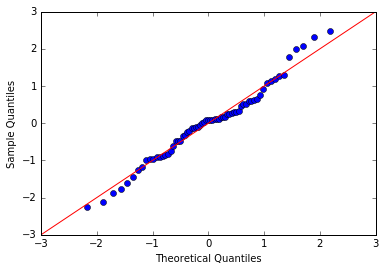

In [7]:
%matplotlib inline
import statsmodels.api as sm
fig = sm.qqplot(ypred_train - ytrain, fit=True, line='45')

## 2. Selección de Atributos

In [8]:
from matplotlib import pyplot as plt
%matplotlib inline

# función para plotear la presente sección de Selección de atributos
def plot(training, test, desc=True):
    x_training, y_training = zip(*training)
    x_test, y_test = zip(*test)
    ax = plt.subplot(111)
    ax.plot(x_training, y_training, color="b", linestyle="-", marker='o', label='Training set')
    ax.plot(x_test, y_test, color="r", linestyle="-", marker='o', label='Test set')

    if desc:
        ax.set_xlim(max(x_training), min(x_training))

    ax.set_ylabel('MSE')
    ax.set_xlabel(u'Número de atributos')
    plt.legend(loc=1)

Xm_train = Xtrain.as_matrix()
ym_train = ytrain.as_matrix()
Xm_test = Xtest.as_matrix()
ym_test = ytest.as_matrix()

### a. Forward Step-wise Selection

El criterio de selección implementado en Forward stepwise selection (FSS), se basa en el cálculo del z score de cada atributo candidato. El que posea el z score con el valor absoluto más grande, será el seleccionado para ser agregado al modelo. El primero en ser seleccionado es el **intercepto**. Luego, el orden de selección de los restantes atributos es: **lcavol**, **lweight**, **svi**, **lbph**, **pgg45**, **lcp**, **age** y finalmente **gleason**.

In [9]:
def fss(x, y, names_x, test_data, k=10000):
    p = x.shape[1]
    k = min(p, k)
    names_x = np.array(names_x)
    remaining = range(0, p)
    selected = []
    points_training = []
    points_test = []
    while remaining and len(selected) <= k:
        score_candidates = []
        for candidate in remaining:
            model = lm.LinearRegression(fit_intercept=False)
            indexes = selected + [candidate]
            x_train = x[:, indexes]
            model.fit(x_train, y)  # fitting with training data

            # predicting training data
            predictions_train = model.predict(x_train)
            residuals_train = predictions_train - y

            # predicting test data
            x_test, y_test = test_data
            x_test = x_test[:, indexes]
            predictions_test = model.predict(x_test)
            residuals_test = predictions_test - y_test

            mse_candidate = np.mean(np.power(residuals_train, 2))
            mse_test = np.mean(np.power(residuals_test, 2))

            # Computing z scores
            var = (mse_candidate * x_train.shape[0]) / (x_train.shape[0] - x_train.shape[1] - 1)
            diag_values = np.diag(np.linalg.pinv(np.dot(x_train.T, x_train)))
            z_scores = np.divide(model.coef_, np.sqrt(np.multiply(var, diag_values)))

            # getting the z score that belongs to the last feature added
            z_score_candidate = z_scores[-1]

            # Using absolute value of the z score
            score_candidates.append((abs(z_score_candidate), mse_candidate, mse_test, candidate))

        score_candidates.sort()
        best_new_z_score, mse_candidate, mse_test, best_candidate = score_candidates.pop()
        remaining.remove(best_candidate)
        selected.append(best_candidate)
        points_training.append((len(selected), mse_candidate))
        points_test.append((len(selected), mse_test))
        print "selected= %s..." % names_x[best_candidate]
        print "totalvars=%d, best z_score = %f, mse = %f" % (len(indexes), best_new_z_score, mse_candidate)
    return selected, points_training, points_test

selected= intercept...
totalvars=1, best z_score = 16.493179, mse = 1.437036
selected= lcavol...
totalvars=2, best z_score = 8.624576, mse = 0.664606
selected= lweight...
totalvars=3, best z_score = 3.554040, mse = 0.553610
selected= svi...
totalvars=4, best z_score = 1.969567, mse = 0.521011
selected= lbph...
totalvars=5, best z_score = 1.972368, mse = 0.489776
selected= pgg45...
totalvars=6, best z_score = 1.181048, mse = 0.478648
selected= lcp...
totalvars=7, best z_score = 1.719063, mse = 0.455818
selected= age...
totalvars=8, best z_score = 1.473839, mse = 0.439363
selected= gleason...
totalvars=9, best z_score = 0.145411, mse = 0.439200


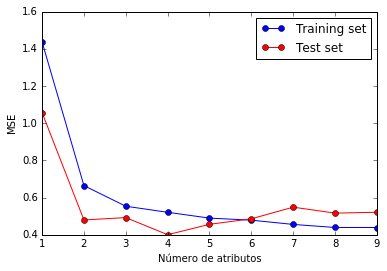

In [10]:
names_regressors = ["lcavol", "lweight", "age", "lbph", "svi", "lcp", "gleason", "pgg45", "intercept"]
selected, points_training, points_test = fss(Xm_train, ym_train, names_regressors, (Xm_test, ym_test))
plot(points_training, points_test, desc=False)

En la figura de arriba, se presenta el error cuadrático medio (mse) en función del número de atributos utilizados para construir el modelo de regresión lineal. Ahí se ve que para el conjunto de entrenamiento, el mse siempre disminuye a medida de que se agregan más predictores al modelo. Sin embargo, para el set de pruebas no es lo mismo. El mse desciende hasta el mínimo de 3 atributos (**lcavol**, **lweight**, **svi** más el **intercepto**), para luego comenzar a aumentar a medida que el modelo se hace más complejo.

### b. Backward Step-wise Selection

Al utilizar Backward stepwise selection (bss), se comienza con un modelo considerando todos los predictores.
Por cada iteración, se elimina el atributo que obtiene el menor z score en valor absoluto. Los resultados obtenidos con el algoritmo implementado, se muestran a continuación.

In [11]:
def bss(x, y, names_x, test_data, k=10000):
    p = x.shape[1]
    k = min(p, k)
    names_x = np.array(names_x)
    selected = range(0, p)
    removed = []
    points_training = []
    points_test = []
    while len(selected) >= 1:
        model = lm.LinearRegression(fit_intercept=False)
        indexes = selected
        x_train = x[:, indexes]
        model.fit(x_train, y)  # fitting with training data

        # predicting training data
        predictions_train = model.predict(x_train)
        residuals_train = predictions_train - y

        # predicting test data
        x_test, y_test = test_data
        x_test = x_test[:, indexes]
        predictions_test = model.predict(x_test)
        residuals_test = predictions_test - y_test

        mse_train = np.mean(np.power(residuals_train, 2))
        mse_test = np.mean(np.power(residuals_test, 2))

        # Computing z scores
        var = (mse_train * x_train.shape[0]) / (x_train.shape[0] - x_train.shape[1] - 1)
        diag_values = np.diag(np.linalg.pinv(np.dot(x_train.T, x_train)))
        z_scores = np.divide(model.coef_, np.sqrt(np.multiply(var, diag_values)))
        score_candidates = zip(np.abs(z_scores), indexes)
        score_candidates.sort(reverse=True)

        # removing the worst
        worst_new_z_score, worst_candidate = score_candidates.pop()
        selected.remove(worst_candidate)
        removed.append(worst_candidate)

        points_training.append((len(indexes) + 1, mse_train))
        points_test.append((len(indexes) + 1, mse_test))
        print "selected= %s..." % names_x[worst_candidate]
        print "totalvars=%d, worst z_score = %f, mse = %f" % (len(indexes), worst_new_z_score, mse_train)
    return removed, points_training, points_test

selected= gleason...
totalvars=8, worst z_score = 0.145411, mse = 0.439200
selected= age...
totalvars=7, worst z_score = 1.473839, mse = 0.439363
selected= lcp...
totalvars=6, worst z_score = 1.719063, mse = 0.455818
selected= pgg45...
totalvars=5, worst z_score = 1.181048, mse = 0.478648
selected= lbph...
totalvars=4, worst z_score = 1.972368, mse = 0.489776
selected= svi...
totalvars=3, worst z_score = 1.969567, mse = 0.521011
selected= lweight...
totalvars=2, worst z_score = 3.554040, mse = 0.553610
selected= lcavol...
totalvars=1, worst z_score = 8.624576, mse = 0.664606
selected= intercept...
totalvars=0, worst z_score = 16.493179, mse = 1.437036


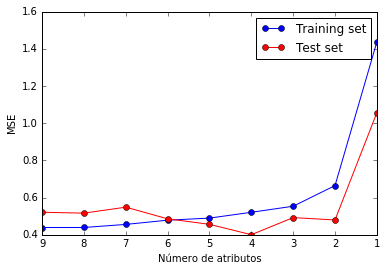

In [12]:
names_regressors = ["lcavol", "lweight", "age", "lbph", "svi", "lcp", "gleason", "pgg45", "intercept"]
removed, points_training, points_test = bss(Xm_train, ym_train, names_regressors, (Xm_test, ym_test))
plot(points_training, points_test)

Como se puede observar arriba, los resultados eran predecibles en el sentido de que se ocupa el mismo criterio que en fss, pero a la inversa. Para el set de entrenamiento, con más predictores se tiene un menor mse. Para el caso del set de pruebas, el mse mínimo se obtiene con 3 atributos predictores más el intercepto.

## 3. Regularización

### a. Ridge Regression

Se ajustó un modelo lineal del dataset, utilizando regresión de Ridge, variando el parámetro $\lambda$ de regularización en el rango $[10^{−1} , 10^4]$.

In [20]:
X = X.drop('intercept', axis=1)
Xtrain = X[istrain]
ytrain = y[istrain]

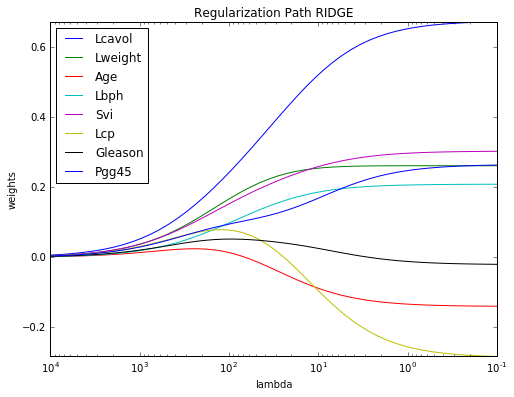

In [26]:
from sklearn.linear_model import Ridge

names_regressors = ["Lcavol", "Lweight", "Age", "Lbph", "Svi", "Lcp", "Gleason", "Pgg45"]

alphas_ = np.logspace(4,-1,base=10)
coefs = []
model = Ridge(fit_intercept=True,solver='svd')
for a in alphas_:
    model.set_params(alpha=a)
    model.fit(Xtrain, ytrain)
    coefs.append(model.coef_)

plt.figure(figsize=(8,6))
ax = plt.gca()
for y_arr, label in zip(np.squeeze(coefs).T, names_regressors):
    plt.plot(alphas_, y_arr, label=label)

ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1]) # reverse axis
plt.xlabel('lambda')
plt.ylabel('weights')
plt.title('Regularization Path RIDGE')
plt.axis('tight')
plt.legend(loc=2)

Arriba, se puede ver el efecto de la variación de $\lambda$ en los coeficientes de los
atributos predictores. Ahí se observa que $\lambda$ tiene poco efecto hasta alcanza un valor entre $10^1$ y $10^2$ . A partir de un $\lambda = 10^3$ , se puede ver un efecto significativo sobre los coeficientes, los cuales comienzan a acercarse a cero.

### b. Lasso Regression

Ahora, se ajustó un modelo lineal del dataset utilizando regresión de Lasso, variando el parámetro $\lambda$ de regularización en el rango $[10^{−2}, 10^1]$.

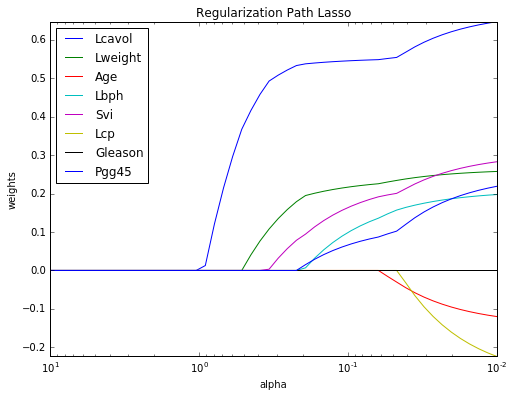

In [27]:
from sklearn.linear_model import Lasso
alphas_ = np.logspace(1, -2, base=10)
model = Lasso(fit_intercept=True)
coefs = []
for a in alphas_:
    model.set_params(alpha=a)
    model.fit(Xtrain, ytrain)
    coefs.append(model.coef_)

plt.figure(figsize=(8,6))
ax = plt.gca()
for y_arr, label in zip(np.squeeze(coefs).T, names_regressors):
    plt.plot(alphas_, y_arr, label=label)

ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Regularization Path Lasso')
plt.axis('tight')
plt.legend(loc=2)

En la figura de arriba, se puede ver el efecto de la variación de $\lambda$ en los coeficientes de los atributos predictores. Ahí ser observa que con un $\lambda$ un poco menor a $10^{-1}$, prácticamente borra del modelo a los predictores lcp y age. Con un $\lambda$ entre 0.1 y 1, los atributos **lweight**, **svi**, **lbph** y **pgg45** se hacen igual a cero. Con un $\lambda$ mayor a 1, todas los coeficientes de los atributos se hacen cero.

### c. Errores de entrenamiento y pruebas (Ridge Regression)

Utilizando regresión de Ridge para generar un modelo lineal, se evaluaron los errores de entrenamiento y de
pruebas, en función del parámetro de regularización $\lambda$, variando el valor de este último en el rango $[10^{−2}, 10^2]$.

MSE mínimo de test (Ridge):  0.485847414042


(100.0, 0.01)

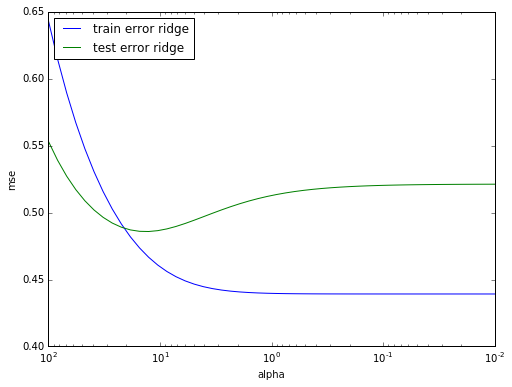

In [29]:
Xtest = X[np.logical_not(istrain)]
ytest = y[np.logical_not(istrain)]
alphas_ = np.logspace(2, -2, base=10)
coefs = []
model = Ridge(fit_intercept=True)
mse_test = []
mse_train = []
for a in alphas_:
    model.set_params(alpha=a)
    model.fit(Xtrain, ytrain)
    yhat_train = model.predict(Xtrain)
    yhat_test = model.predict(Xtest)
    mse_train.append(np.mean(np.power(yhat_train - ytrain, 2)))
    mse_test.append(np.mean(np.power(yhat_test - ytest, 2)))

print "MSE mínimo de test (Ridge): ", min(mse_test)
plt.figure(figsize=(8,6))
ax = plt.gca()
ax.plot(alphas_, mse_train, label='train error ridge')
ax.plot(alphas_, mse_test, label='test error ridge')
plt.legend(loc=2)
plt.xlabel('alpha')
plt.ylabel('mse')
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])

En la figura de arriba, se observa que ambos mse disminuyen a medida que $\lambda$ disminuye. 
A partir de $\lambda = 1$ los errores se estabilizan. El de test lo hace en $\approx$ 0,5 y el de entrenamiento en  $\approx$ 0,45. **El mse mínimo de test es aproximadamente de 0,486**.

### d. Errores de entrenamiento y pruebas (Lasso Regression)

Utilizando regresión de Lasso para generar un modelo lineal, se evaluaron los errores de entrenamiento y de
pruebas, en función del parámetro de regularización, variando el valor de este último en el rango $[0.5, 10 ^2]$. Sin embargo, con este rango no se logró apreciar ningún tipo de variación del error. Por lo tanto, tal rango se cambió $[10^{−3} , 1]$. El resultado se puede ver a continuación.

MSE mínimo de test (Lasso):  0.452565037028


(1.0, 0.001)

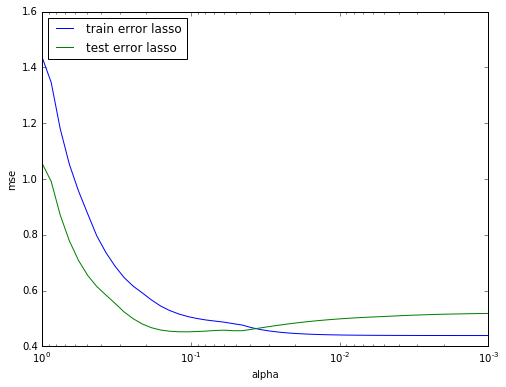

In [32]:
alphas_ = np.logspace(0, -3, base=10)
coefs = []
model = Lasso(fit_intercept=True)
mse_test = []
mse_train = []
for a in alphas_:
    model.set_params(alpha=a)
    model.fit(Xtrain, ytrain)
    yhat_train = model.predict(Xtrain)
    yhat_test = model.predict(Xtest)
    mse_train.append(np.mean(np.power(yhat_train - ytrain, 2)))
    mse_test.append(np.mean(np.power(yhat_test - ytest, 2)))

print "MSE mínimo de test (Lasso): ", min(mse_test)
plt.figure(figsize=(8,6))
ax = plt.gca()
ax.plot(alphas_, mse_train, label='train error lasso')
ax.plot(alphas_, mse_test, label='test error lasso')
plt.xlabel('alpha')
plt.ylabel('mse')
plt.legend(loc=2)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])

Con esto, se observa que con un $\lambda = 1$, ambos mse disminuyen bruscamente, hasta estabilizarse en torno a 0,5 de error. El mse mínimo de test es igual 0.453, para luego ascender y mantenerse en torno a los 0,5.

### e. Estimación del valor de regularización con cross-validation

Usando validación cruzada, se determinó el mejor valor del parámetro de regularización para los métodos Ridge
y Lasso Regression. Los resultados pueden verse en la siguiente tabla. 

Método | rango $\lambda$        | Mejor param.  | MSE
-------|------------------------|---------------|-----------
Ridge  | $[10^{-2}, 10^2]$      | 2.33          | 0.752
Lasso  | $[10^{-3}, 10^0]$      | 0.004         | 0.756

Si se compara con los valores mínimos obtenidos en la sección de Regularización (Ridge: 0.486 y Lasso: 0.453), se obtienen mse mayores cuando utilizando validación cruzada en vez de utilizar un set de pruebas separado para realizar los tests. Lo anterior podría explicarse por el hecho de que al usar validación cruzada, se utiliza una menor cantidad de datos para entrenar el modelo que cuando se usa el método ordinario con el set completo de entrenamiento. Esto radica en un aprendizaje más pobre del problema por parte del modelo de regresión.

In [33]:
from sklearn import cross_validation
from sklearn.metrics import mean_squared_error

def best_parameter(x, y, method, alphas):
    Xm = x.as_matrix()
    ym = y.as_matrix()

    if method == "lasso":
        model = Lasso(fit_intercept=True)
    elif method == "ridge":
        model = Ridge(fit_intercept=True)

    k_fold = cross_validation.KFold(len(Xm), 10)
    best_cv_mse = float("inf")

    for a in alphas:
        model.set_params(alpha=a)
        mse_list_k10 = [
                    mean_squared_error(model.fit(Xm[train], ym[train]).predict(Xm[val]), ym[val])
                    for train, val in k_fold]
        if np.mean(mse_list_k10) < best_cv_mse:
            best_cv_mse = np.mean(mse_list_k10)
            best_alpha = a
            print method, "BEST PARAMETER=%f, MSE(CV)=%f" % (best_alpha, best_cv_mse)


In [34]:
print "Valor de regularización de Ridge\n"
best_parameter(Xtrain, ytrain, 'ridge', np.logspace(2, -2, base=10))
print "\n\nValor de regularización de Ridge\n"
best_parameter(Xtrain, ytrain, 'lasso', np.logspace(0, -3, base=10))

Valor de regularización de Ridge

ridge BEST PARAMETER=100.000000, MSE(CV)=0.999646
ridge BEST PARAMETER=82.864277, MSE(CV)=0.965780
ridge BEST PARAMETER=68.664885, MSE(CV)=0.935286
ridge BEST PARAMETER=56.898660, MSE(CV)=0.908007
ridge BEST PARAMETER=47.148664, MSE(CV)=0.883727
ridge BEST PARAMETER=39.069399, MSE(CV)=0.862205
ridge BEST PARAMETER=32.374575, MSE(CV)=0.843206
ridge BEST PARAMETER=26.826958, MSE(CV)=0.826516
ridge BEST PARAMETER=22.229965, MSE(CV)=0.811949
ridge BEST PARAMETER=18.420700, MSE(CV)=0.799351
ridge BEST PARAMETER=15.264180, MSE(CV)=0.788588
ridge BEST PARAMETER=12.648552, MSE(CV)=0.779537
ridge BEST PARAMETER=10.481131, MSE(CV)=0.772077
ridge BEST PARAMETER=8.685114, MSE(CV)=0.766076
ridge BEST PARAMETER=7.196857, MSE(CV)=0.761390
ridge BEST PARAMETER=5.963623, MSE(CV)=0.757863
ridge BEST PARAMETER=4.941713, MSE(CV)=0.755328
ridge BEST PARAMETER=4.094915, MSE(CV)=0.753618
ridge BEST PARAMETER=3.393222, MSE(CV)=0.752571
ridge BEST PARAMETER=2.811769, MSE(CV)=0